## Setup and Import Libraries

In [22]:
import time
import pickle
import numpy as np
import pandas as pd
import vertexai
import matplotlib.pyplot as plt
import mplcursors
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.ensemble import IsolationForest, RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from vertexai.language_models import TextEmbeddingModel
from google.cloud import bigquery
from utils import authenticate, clusters_2D, encode_text_to_embedding_batched

import warnings
warnings.filterwarnings('ignore')

In [3]:
credentials, PROJECT_ID = authenticate()

In [4]:
REGION = 'us-central1'

In [5]:
vertexai.init(
    project=PROJECT_ID, 
    location=REGION, 
    credentials=credentials
)

In [6]:
embedding_model = TextEmbeddingModel.from_pretrained("text-embedding-005")

## Load Stack Overflow questions and answers from BigQuery

In [7]:
def run_bq_query(sql):

    # Create BQ client
    bq_client = bigquery.Client(
        project = PROJECT_ID,
        credentials = credentials
    )

    # Try dry run before executing query to catch any errors
    job_config = bigquery.QueryJobConfig(
        dry_run=True,
        use_query_cache=False
    )
    bq_client.query(sql, job_config=job_config)

    # If dry run succeeds without errors, proceed to run query
    job_config = bigquery.QueryJobConfig()
    
    client_result = bq_client.query(
        sql, job_config=job_config
    )

    job_id = client_result.job_id

    # Wait for query/job to finish running. then get & return data frame
    df = client_result.result().to_arrow().to_pandas()
    print(f"Finished job_id: {job_id}")
    return df

In [8]:
language_list = ["python", "html", "r", "css"]

In [9]:
so_df = pd.DataFrame()

for language in language_list:
    
    print(f"generating {language} dataframe")
    
    query = f"""
    SELECT
        CONCAT(q.title, q.body) as input_text,
        a.body AS output_text
    FROM
        `bigquery-public-data.stackoverflow.posts_questions` q
    JOIN
        `bigquery-public-data.stackoverflow.posts_answers` a
    ON
        q.accepted_answer_id = a.id
    WHERE 
        q.accepted_answer_id IS NOT NULL AND 
        REGEXP_CONTAINS(q.tags, "{language}") AND
        a.creation_date >= "2020-01-01"
    LIMIT 
        500
    """

    
    language_df = run_bq_query(query)
    language_df["category"] = language
    so_df = pd.concat([so_df, language_df], ignore_index = True)

generating python dataframe
Finished job_id: 6cf456b9-9366-41a5-8895-b3a5b826c511
generating html dataframe
Finished job_id: 12091c26-2e4d-4a77-b75e-77749aed8f08
generating r dataframe
Finished job_id: 779f09ff-b237-4928-ab10-6879b4fd5c55
generating css dataframe
Finished job_id: ef68617b-2b08-4e23-a3e4-84ebcfdc7d49


In [10]:
so_df

,input_text,output_text,category
0,Use newline='' with click.open_file() to suppo...,<p>According to the issue discussions on Githu...,python
1,Selection of the three largest values in the n...,<p>This:</p>\n<pre><code>np.argsort(probabilit...,python
2,How to print different functions according to ...,<p>You can change <code>1</code> to <code>'1'<...,python
3,I'm trying to impute NA values in engine_capac...,"<p>try:</p>\n<pre class=""lang-py prettyprint-o...",python
4,Pandas dataframe - find last timestamp with va...,"<p>You can use <a href=""https://pandas.pydata....",python
...,...,...,...
1995,How to make bootstrap column height to remaini...,<p>I would make the container column relative ...,css
1996,"on selecting radio button, div is not displayi...",<p>Your are only missing the default show for ...,css
1997,How can I make equal-width items based on the ...,<p>CSS-Grid can do that without wrapping the i...,css
1998,Alternating line-break for two div-containers ...,<p>There's probably a ton of edge cases that n...,css


## Generate Text Embeddings

In [11]:
def generate_batches(sentences, batch_size = 5):
    for i in range(0, len(sentences), batch_size):
        yield sentences[i : i + batch_size]

In [12]:
so_questions = so_df[0:200].input_text.tolist() 

batches = generate_batches(sentences = so_questions)

In [13]:
batch = next(batches)
len(batch)

5

## Get embeddings on a batch of data

In [26]:
def encode_texts_to_embeddings(sentences):
    try:
        embeddings = model.get_embeddings(sentences)
        return [embedding.values for embedding in embeddings]
    except Exception:
        return [None for _ in range(len(sentences))]

In [27]:
batch_embeddings = encode_texts_to_embeddings(batch)

In [28]:
so_df.head()

,input_text,output_text,category
0,Use newline='' with click.open_file() to suppo...,<p>According to the issue discussions on Githu...,python
1,Selection of the three largest values in the n...,<p>This:</p>\n<pre><code>np.argsort(probabilit...,python
2,How to print different functions according to ...,<p>You can change <code>1</code> to <code>'1'<...,python
3,I'm trying to impute NA values in engine_capac...,"<p>try:</p>\n<pre class=""lang-py prettyprint-o...",python
4,Pandas dataframe - find last timestamp with va...,"<p>You can use <a href=""https://pandas.pydata....",python


In [29]:
with open('question_embeddings_app.pkl', 'rb') as file:
    question_embeddings = pickle.load(file)

In [30]:
print("Shape: " + str(question_embeddings.shape))
print(question_embeddings)

Shape: (2000, 768)
[[-0.03571156 -0.00240684  0.05860338 ... -0.03100227 -0.00855574
  -0.01997405]
 [-0.02024316 -0.0026255   0.01940405 ... -0.02158143 -0.05655403
  -0.01040497]
 [-0.05175979 -0.03712264  0.02699278 ... -0.07055898 -0.0402537
   0.00092099]
 ...
 [-0.00580394 -0.01621097  0.05829635 ... -0.03350992 -0.05343556
  -0.06016821]
 [-0.00436622 -0.02692963  0.03363771 ... -0.01686567 -0.03812337
  -0.02329491]
 [-0.04240424 -0.01633749  0.05516777 ... -0.02697376 -0.01751165
  -0.04558187]]


## Cluster the embeddings of the Stack Overflow questions

In [31]:
clustering_dataset = question_embeddings[:1000]

In [32]:
n_clusters = 2

In [33]:
kmeans = KMeans(
    n_clusters=n_clusters,
    random_state=0, 
    n_init = 'auto'
).fit(clustering_dataset)

In [34]:
kmeans_labels = kmeans.labels_

In [35]:
PCA_model = PCA(n_components=2)
PCA_model.fit(clustering_dataset)
new_values = PCA_model.transform(clustering_dataset)

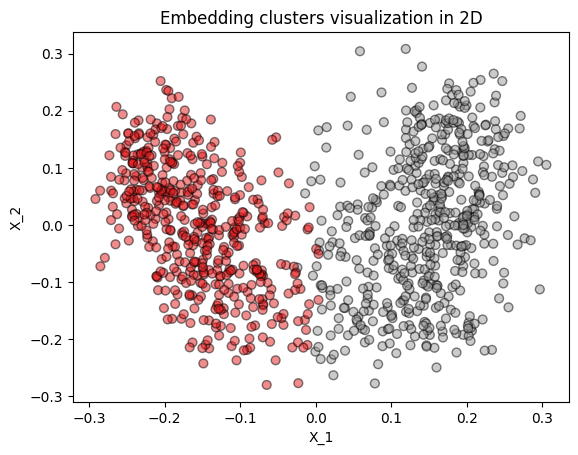

In [36]:
clusters_2D(
    x_values = new_values[:,0], 
    y_values = new_values[:,1], 
    labels = so_df[:1000], 
    kmeans_labels = kmeans_labels
)

## Anomaly / Outlier Detection

In [37]:
input_text = """I am making cookies but don't 
                remember the correct ingredient proportions. 
                I have been unable to find 
                anything on the web."""

In [39]:
embeddings = embedding_model.get_embeddings([input_text])[0].values

In [40]:
embeddings_l = question_embeddings.tolist()
embeddings_l.append(embeddings)

In [41]:
embeddings_array = np.array(embeddings_l)

In [42]:
print("Shape: " + str(embeddings_array.shape))
print(embeddings_array)

Shape: (2001, 768)
[[-0.03571156 -0.00240684  0.05860338 ... -0.03100227 -0.00855574
  -0.01997405]
 [-0.02024316 -0.0026255   0.01940405 ... -0.02158143 -0.05655403
  -0.01040497]
 [-0.05175979 -0.03712264  0.02699278 ... -0.07055898 -0.0402537
   0.00092099]
 ...
 [-0.00436622 -0.02692963  0.03363771 ... -0.01686567 -0.03812337
  -0.02329491]
 [-0.04240424 -0.01633749  0.05516777 ... -0.02697376 -0.01751165
  -0.04558187]
 [-0.04104147  0.03503685 -0.00564984 ...  0.01765895  0.04067332
  -0.07284944]]


In [43]:
new_row = pd.Series([input_text, None, "baking"], index=so_df.columns)
so_df.loc[len(so_df)+1] = new_row
so_df.tail()

,input_text,output_text,category
1996,"on selecting radio button, div is not displayi...",<p>Your are only missing the default show for ...,css
1997,How can I make equal-width items based on the ...,<p>CSS-Grid can do that without wrapping the i...,css
1998,Alternating line-break for two div-containers ...,<p>There's probably a ton of edge cases that n...,css
1999,Make div dropdown navbar elements the same siz...,<p>The little bit of Googling I did seems to i...,css
2001,I am making cookies but don't \n ...,None,baking


### Use Isolation Forest to identify potential outliers

- IsolationForest classifier will predict -1 for potential outliers, and 1 for non-outliers.
- You can inspect the rows that were predicted to be potential outliers and verify that the question about baking is predicted to be an outlier.

In [44]:
classifier = IsolationForest(contamination=0.005, random_state=2) 

In [45]:
predictions = classifier.fit_predict(embeddings_array)

print(f"{len(predictions)} predictions. Set of possible values: {set(predictions)}")

2001 predictions. Set of possible values: {np.int64(1), np.int64(-1)}


In [47]:
so_df.loc[predictions == -1]

,input_text,output_text,category
51,dataflow error with sdk_container_image apache...,"<p>There is a common issue in this case, are y...",python
486,Postgres update returning value giving string ...,"<p>Ok, so I found the solution. It turns out b...",python
1018,get height of element on buildtime to adapt el...,<p>You can use <code>Positioned.fill</code> wi...,r
1220,Should django migrations be applied automatica...,"<p>If some people do and some don't, you can e...",r
1250,how to get time difference form formatted time...,<p>You just need to get the minutes instead of...,r
1313,Why the logs are not update?<p>I have a simple...,<p><strong>For Airflow&gt;=2.4.0:</strong></p>...,r
1403,How to make a sequence of functions in REBOL?<...,<p><code>mul2</code> and <code>mul3</code> are...,r
1427,Is there a way to put a anchor component in an...,<p>Have you set the text content for your <cod...,r
1498,Why my state is not getting set inside class b...,<p>this.setState is an asynchronous function<b...,r
2001,I am making cookies but don't \n ...,None,baking


### Remove the outlier about baking

In [48]:
so_df = so_df.drop(so_df.index[-1])
so_df

,input_text,output_text,category
0,Use newline='' with click.open_file() to suppo...,<p>According to the issue discussions on Githu...,python
1,Selection of the three largest values in the n...,<p>This:</p>\n<pre><code>np.argsort(probabilit...,python
2,How to print different functions according to ...,<p>You can change <code>1</code> to <code>'1'<...,python
3,I'm trying to impute NA values in engine_capac...,"<p>try:</p>\n<pre class=""lang-py prettyprint-o...",python
4,Pandas dataframe - find last timestamp with va...,"<p>You can use <a href=""https://pandas.pydata....",python
...,...,...,...
1995,How to make bootstrap column height to remaini...,<p>I would make the container column relative ...,css
1996,"on selecting radio button, div is not displayi...",<p>Your are only missing the default show for ...,css
1997,How can I make equal-width items based on the ...,<p>CSS-Grid can do that without wrapping the i...,css
1998,Alternating line-break for two div-containers ...,<p>There's probably a ton of edge cases that n...,css


## Classification

In [49]:
X = question_embeddings
X.shape

(2000, 768)

In [50]:
y = so_df['category'].values
y.shape

(2000,)

In [51]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=2
)

In [52]:
classifier = RandomForestClassifier(n_estimators=200)

In [53]:
classifier.fit(X_train, y_train)

,n_estimators,200
,criterion,'gini'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [54]:
predictions = classifier.predict(X_test)

In [55]:
accuracy = accuracy_score(y_true=y_test, y_pred=predictions)
print("Accuracy:", accuracy)

Accuracy: 0.69


### Try out the classifier on some questions

In [57]:
i = 2
label = so_df.loc[i,'category']
question = so_df.loc[i,'input_text']

# get the embedding of this question and predict its category
question_embedding = embedding_model.get_embeddings([question])[0].values
pred = classifier.predict([question_embedding])

print(f"For question {i}, the prediction is `{pred[0]}`")
print(f"The actual label is `{label}`")
print("The question text is:")
print("-"*50)
print(question)

For question 2, the prediction is `r`
The actual label is `python`
The question text is:
--------------------------------------------------
How to print different functions according to a given input<p>I'm learning python since  few weeks ago and I need some help with a code. I'm triying to run a code that display certain value according to the input given by the user, so if user enters 1, x value is shown. I've tried a lot of different ways to do it but surely I'm skipping or ignoring something. How could I make this work? Thanks. (This code only prints second_statement no matter what the user inputs).</p>
<pre><code>def first_statement(x):
    print(&quot;xxxx&quot;)

def second_statement(x):
    print(&quot;yyyy&quot;)

x = input(&quot;If you want x thing press 1, otherwise, press 2: &quot;)

if x == 1:
    print(first_statement(x))

else:
    print(second_statement(x))

</code></pre>
